In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
#import plotly.graph_objs as go
import plotly.graph_objects as go
cf.go_offline()
cf.set_config_file(offline = True)
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Specify the ticker symbol for Yahoo Finance Data (ADBE)
ticker = ['ADBE']

In [50]:
df = yf.download(ticker,start = '2010-01-01', end='2022-12-31').dropna()

[*********************100%***********************]  1 of 1 completed


### EXPLORATORY DATA ANALYSIS

In [51]:
# Checking if there is any missing values
df.isnull().values.any()

False

In [52]:
# Analysing the statistic summary of the dataframe
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3272.000000,3272.000000,3272.000000,3272.000000,3272.000000,3.272000e+03
mean,186.068857,188.254349,183.667182,186.068298,186.068298,3.813703e+06
std,173.554604,175.666975,171.105878,173.459523,173.459523,3.597777e+06
min,22.969999,23.360001,22.670000,22.690001,22.690001,5.892000e+05
25%,42.772499,43.409999,42.552500,42.910000,42.910000,2.122025e+06
50%,97.664997,98.309998,96.985001,97.755001,97.755001,2.948050e+06
75%,289.360008,292.534996,284.534996,287.970001,287.970001,4.363275e+06
max,696.280029,699.539978,678.909973,688.369995,688.369995,1.087524e+08


In [53]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,36.650002,37.299999,36.650002,37.090000,37.090000,4710200
2010-01-05,37.040001,37.799999,36.869999,37.700001,37.700001,7108800
2010-01-06,37.330002,37.740002,37.200001,37.619999,37.619999,5336400
2010-01-07,37.410000,37.590000,36.810001,36.889999,36.889999,5576700
2010-01-08,36.750000,36.970001,36.340000,36.689999,36.689999,5429200


##### The data contains open price, high price, low price, close price, adj close price, and volume for the stock. The following table shows the Adobe stock price data from beginning of 2010.

In [54]:
# we first select the 'Adj Close' column from a DataFrame df using the syntax df['Adj Close']. 
# This returns a Pandas Series object containing the adjusted closing prices for a particular security (represented by the ticker symbol ADBE).
df_adj_close = df['Adj Close']
df_adj_close = df_adj_close.to_frame()
df_adj_close.columns = [ticker[0]]
df_adj_close.head()

,ADBE
Date,
2010-01-04,37.090000
2010-01-05,37.700001
2010-01-06,37.619999
2010-01-07,36.889999
2010-01-08,36.689999


In [55]:
# Displaying the change in price between 2010 - 2022 to have a rough idea 
df_adj_close.iplot(title = 'Price Change between 2010 and 2022')

 Stock shows upward trend based on years till 2021 but there is drastic drop in 2022 but a fluctuation can be 
 observed after the mid of 2022 


In [56]:
# Calculating daily return change using the built in function
ret = df_adj_close.pct_change()
ret.iplot(colors = 'Blue',title = 'Daily Return Between 2010 and 2022')

In [57]:
#This function will help in calculating annual risk and return for stocks
def ann_risk_return(returns_df):
    summary = returns_df.agg(["mean", "std"]).T
    summary.columns = ["Return", "Risk"]
    summary.Return = summary.Return*252
    summary.Risk = summary.Risk * np.sqrt(252)
    return summary
summary = ann_risk_return(ret)
summary

,Return,Risk
ADBE,0.220433,0.317046


##### We also calculated aggregated annual return and risk and the result indicates that annual return is 22% and risk is 31%

In [58]:
### calculating the monthly cumulative returns for Adobe stock prices based on past data..

stocks_monthly_price = df_adj_close.resample('M',kind='period').last()
ret_month = stocks_monthly_price.pct_change().dropna()
month_cum_ret = (1+ret_month).cumprod()
month_cum_ret.iplot(color = 'Red')

### Moving Average Comparison for 50,100,200 days
##### Simple Moving Average(SMA) is a stock indicator that is commonly used in finance as technical indicator.
##### The reason for calculating SMA is to get smooth out the stock price data

In [59]:
def cal_sma50_sma100_sma200(df):
    stocks_SMA= pd.DataFrame()
    for stock in df.columns:
        stocks_SMA['{}'.format(stock)] = df[stock]
        stocks_SMA["{} SMA50".format(stock)]=df[stock].rolling(window = 50).mean()
        stocks_SMA["{} SMA100".format(stock)]=df[stock].rolling(window = 100).mean()
        stocks_SMA["{} SMA200".format(stock)]=df[stock].rolling(window = 200).mean()
        
    return stocks_SMA

cal_sma50_sma100_sma200(df_adj_close)

,ADBE,ADBE SMA50,ADBE SMA100,ADBE SMA200
Date,,,,
2010-01-04,37.090000,NaN,NaN,NaN
2010-01-05,37.700001,NaN,NaN,NaN
2010-01-06,37.619999,NaN,NaN,NaN
2010-01-07,36.889999,NaN,NaN,NaN
2010-01-08,36.689999,NaN,NaN,NaN
...,...,...,...,...
2022-12-23,338.450012,323.907799,340.365299,374.445150
2022-12-27,335.089996,324.850799,339.410299,374.038699
2022-12-28,328.329987,325.547399,338.359299,373.622849


In [60]:
moving_avg = cal_sma50_sma100_sma200(df_adj_close)
moving_avg.iplot(title = 'Comparison the moving averages')

### Based on the moving average table, the stock indicate a buy signal since 50 days moving average crosses the 100 days moving average(SMA) though it did not crosses the 200 days moving average(SMA) 

## Annual Return Triangle

In [61]:
## In this part of the data analysis, we take a look at the historical annual return on the stock.
## then we calculated the annual return

## The annual return triangle shows the historical annual returns on 12 years period

annual = df_adj_close.resample("A", kind = "period").last()
annual

,ADBE
Date,
2010,30.780001
2011,28.270000
2012,37.680000
2013,59.880001
2014,72.699997
2015,93.940002
2016,102.949997
2017,175.240005
2018,226.240005


##### created a triangle DataFrame that includes the rolling geometric means of the annualized returns over various time periods after calculating the annualized return for each stock in a given DataFrame df.

In [63]:
annual_log_ret = np.log(annual/annual.shift())
annual_log_ret.dropna(inplace = True)
years = annual_log_ret.index.size

def annual_return_triangle(df,annual_log_ret):
    windows = [year for year in range(years, 0, -1)]
    for i in df.columns:
        for year in windows:
            annual_log_ret["{}{}Y".format(i,year)] = annual_log_ret[i].rolling(year).mean()
    return annual_log_ret

an_ret_tri = annual_return_triangle(df_adj_close,annual_log_ret)

triangle= an_ret_tri.drop(columns = df_adj_close.columns)
print(triangle.columns)
print(triangle)

Index(['ADBE12Y', 'ADBE11Y', 'ADBE10Y', 'ADBE9Y', 'ADBE8Y', 'ADBE7Y', 'ADBE6Y',
       'ADBE5Y', 'ADBE4Y', 'ADBE3Y', 'ADBE2Y', 'ADBE1Y'],
      dtype='object')
       ADBE12Y   ADBE11Y   ADBE10Y    ADBE9Y    ADBE8Y    ADBE7Y    ADBE6Y  \
Date                                                                         
2011       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2012       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2013       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2014       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2015       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2016       NaN       NaN       NaN       NaN       NaN       NaN  0.201230   
2017       NaN       NaN       NaN       NaN       NaN  0.248470  0.304059   
2018       NaN       NaN       NaN       NaN  0.249341  0.297114  0.298744   
2019       NaN       NaN       NaN  0.263517  0.307089  0.30

#### visualizes the yearly returns triangle using a heatmap

In [65]:
def graph_annual_return_triangle(df):
    i=0
    new_list=[]
    while i<len(triangle.columns.values):
        new_list.append(df.columns.values[i:i+years])
        i+=years
    for i in new_list:
        plt.figure(figsize=(30,20))
        sns.set(font_scale=2)
        sns.heatmap(df[i], annot = True, fmt = ".1%", cmap = "RdYlGn")
        plt.tick_params(axis = "y", labelright =True)
    return plt.show()

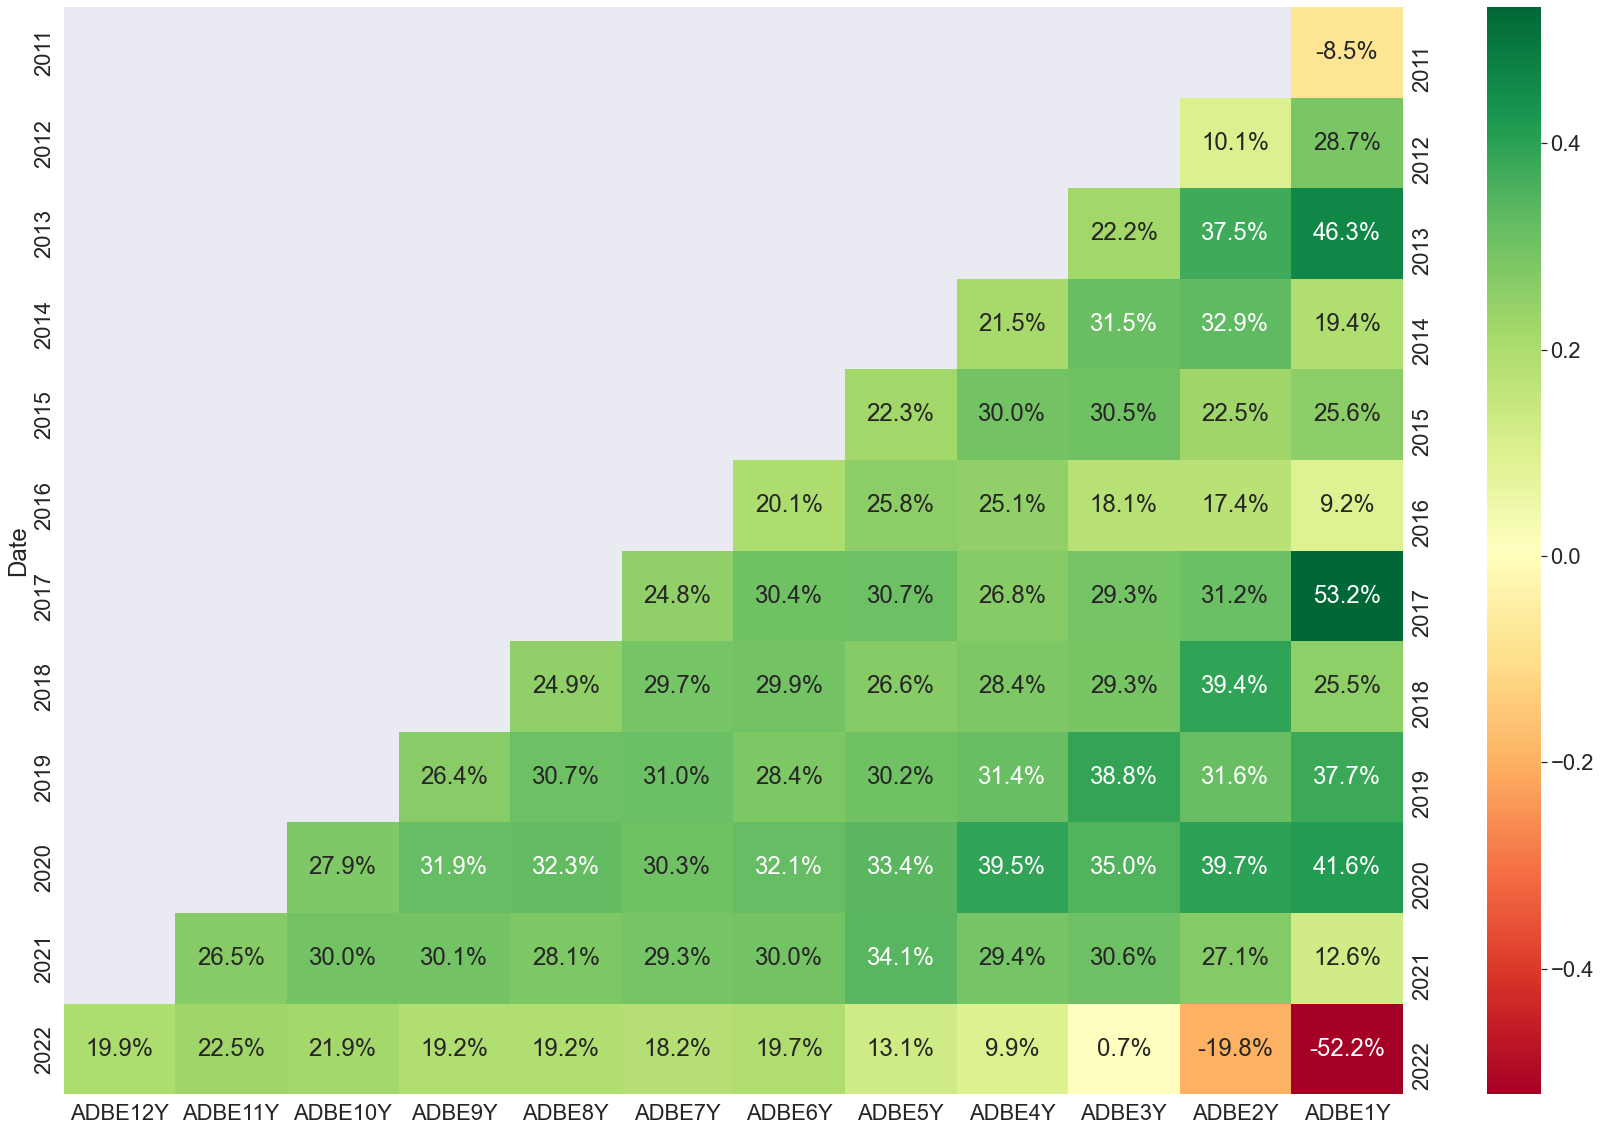

In [66]:
graph_annual_return_triangle(triangle)

By analyzing the following above annual triangle return graph , we can see that in 12 years period, the stock is gained a different percentage of return. For example, ADBE1Y and 2021 intersection show us one-year annual return is 9.2%. if someone buys the stock in 2020 and holds it for one year, he would get 41.6% (2020 and ADBE1Y intersection) while he would loss -8.5% if the stock was bought in 2011 for one-year period.

<Figure size 720x576 with 0 Axes>

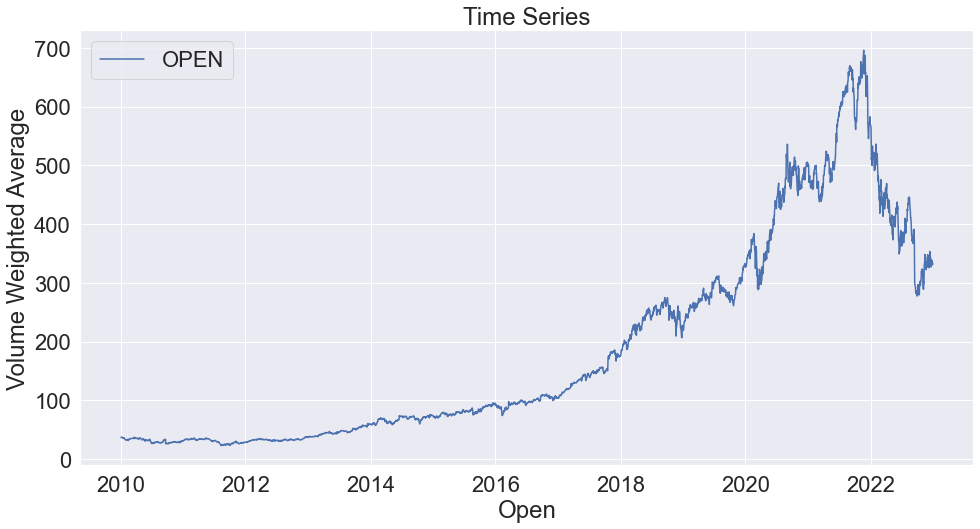

In [68]:
plt.figure(figsize=(10,8))

#  subplot #1
plt.figure(figsize=(16,8)) 
plt.plot(df['Open'], label='OPEN') 
plt.title('Time Series') 
plt.xlabel("Open") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show()  # plot subplots

<Figure size 720x576 with 0 Axes>

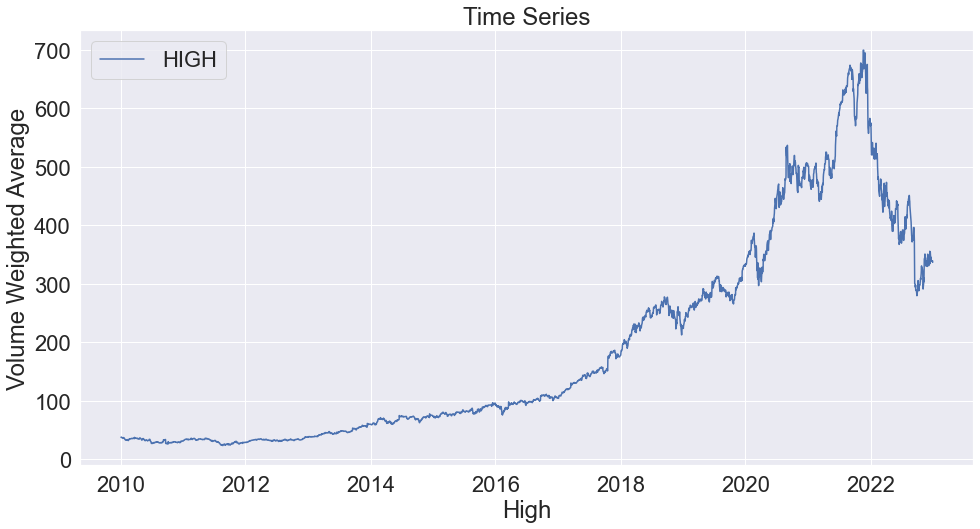

In [69]:
plt.figure(figsize=(10,8))

#  subplot #2
plt.figure(figsize=(16,8)) 
plt.plot(df['High'], label='HIGH') 
plt.title('Time Series') 
plt.xlabel("High") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show()  # plot subplots


<Figure size 720x576 with 0 Axes>

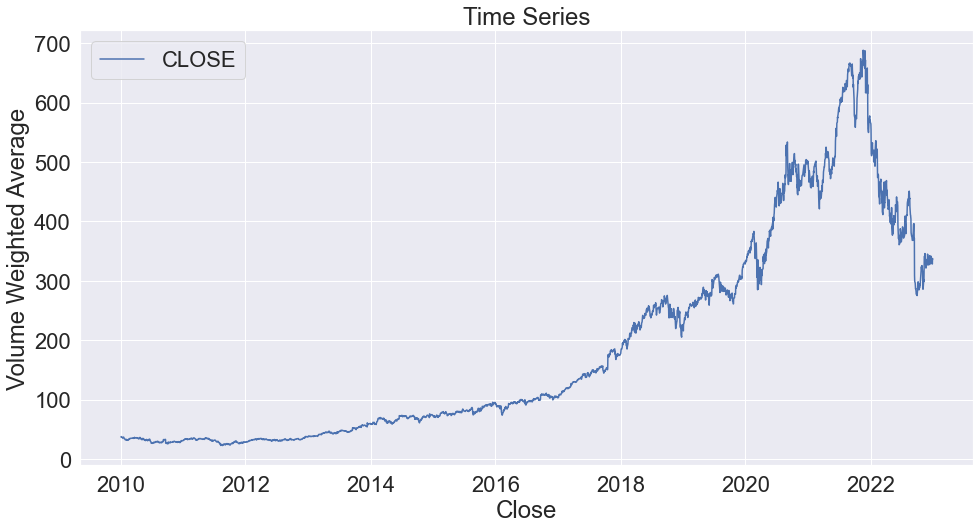

In [70]:
plt.figure(figsize=(10,8))

#  subplot #3
plt.figure(figsize=(16,8)) 
plt.plot(df['Close'], label='CLOSE') 
plt.title('Time Series') 
plt.xlabel("Close") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show()  # plot subplots

<Figure size 720x576 with 0 Axes>

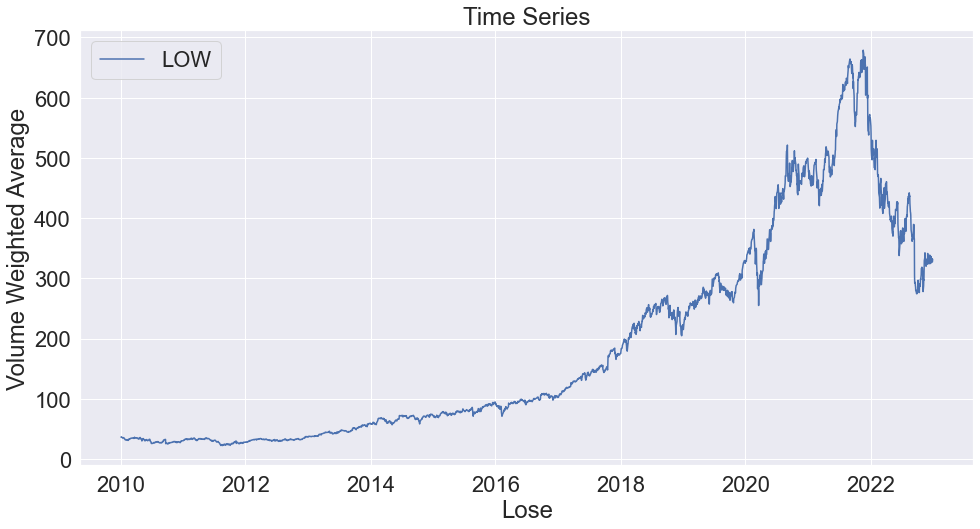

In [71]:
plt.figure(figsize=(10,8))

#  subplot #4
plt.figure(figsize=(16,8)) 
plt.plot(df['Low'], label='LOW') 
plt.title('Time Series') 
plt.xlabel("Lose") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show()  # plot subplots


In [74]:
df['YEAR']  = df.index.strftime("%Y")     # YEAR
df['MONTH'] = df.index.strftime("%Y-%m")  # YEAR-MONTH
df['WEEK']  = df.index.strftime("%Y-%U")  # YEAR-WEEK


#  create time dataframes using GROUPBY
df_yr = df.groupby('YEAR').sum()
df_mh = df.groupby('MONTH').sum()
df_wk = df.groupby('WEEK').sum()


#  print index and column names
print("\nperf_dy:\n", df.index.name, df.columns.values)
print("\nperf_yr:\n", df.index.name, df.columns.values)
print("\nperf_mh:\n", df.index.name, df.columns.values)
print("\nperf_wk:\n", df.index.name, df.columns.values)


perf_dy:
 Date ['Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume' 'YEAR' 'MONTH' 'WEEK']

perf_yr:
 Date ['Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume' 'YEAR' 'MONTH' 'WEEK']

perf_mh:
 Date ['Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume' 'YEAR' 'MONTH' 'WEEK']

perf_wk:
 Date ['Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume' 'YEAR' 'MONTH' 'WEEK']


<Figure size 720x576 with 0 Axes>

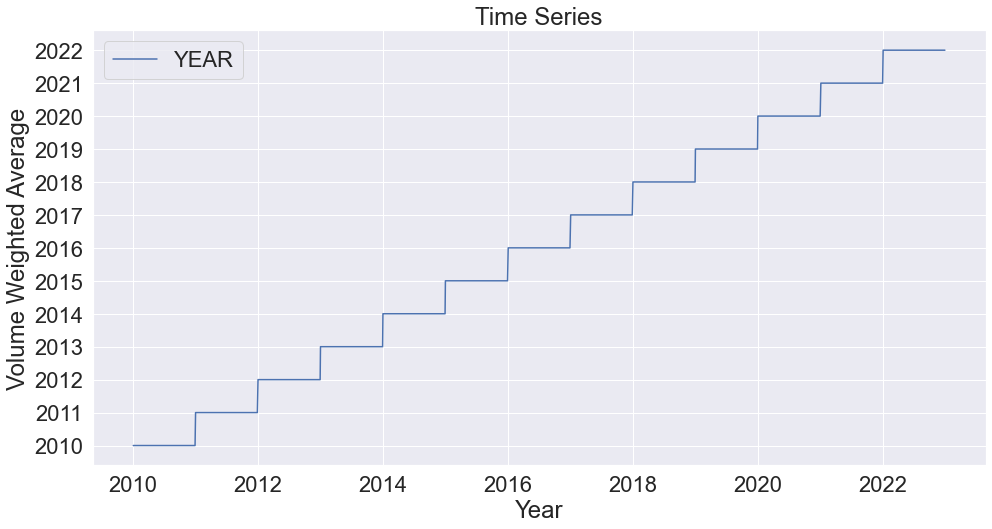

In [75]:
plt.figure(figsize=(10,8))

plt.figure(figsize=(16,8)) 
plt.plot(df['YEAR'], label='YEAR') 
plt.title('Time Series') 
plt.xlabel("Year") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show() 

<Figure size 720x576 with 0 Axes>

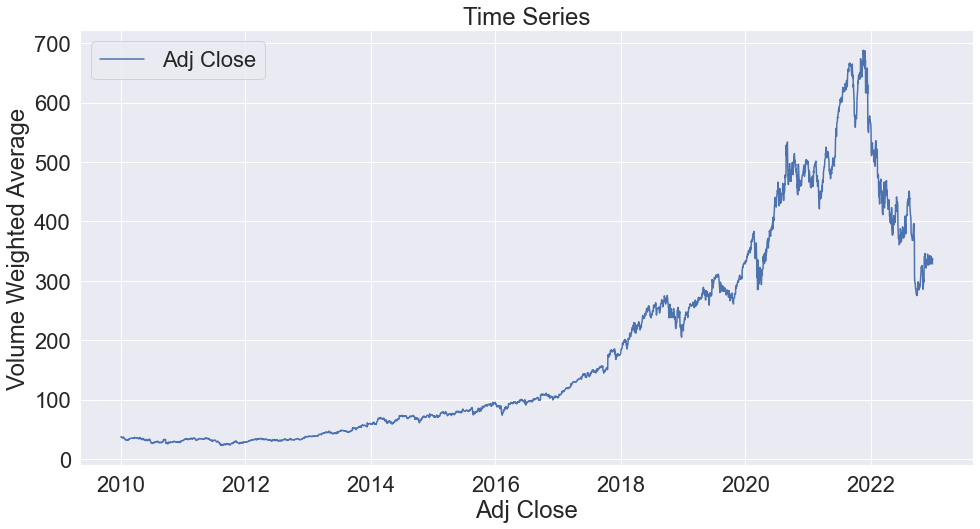

In [76]:
plt.figure(figsize=(10,8))

plt.figure(figsize=(16,8)) 
plt.plot(df['Adj Close'], label='Adj Close') 
plt.title('Time Series') 
plt.xlabel("Adj Close") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show()  # plot subplots

<AxesSubplot:xlabel='YEAR'>

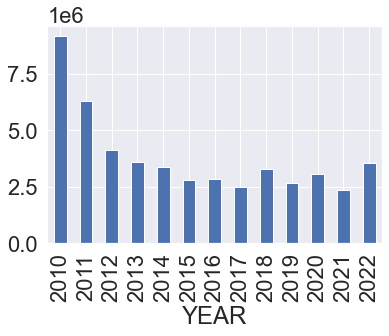

In [77]:
# Yearly Volume for Yahoo Finance Data (ADBE)

df.groupby('YEAR')['Volume'].mean().plot.bar()

<AxesSubplot:xlabel='YEAR'>

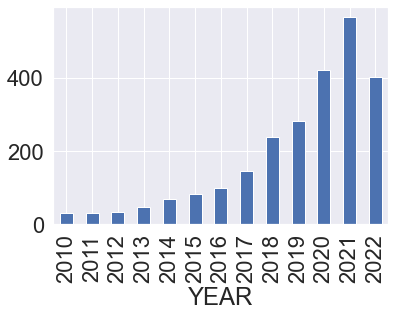

In [78]:
# Yearly High stock for Yahoo Finance Data (ADBE)

df.groupby('YEAR')['High'].mean().plot.bar()

Text(0.5, 1.0, 'Yearly Mean Volume for Yahoo Finance Data (ADBE)')

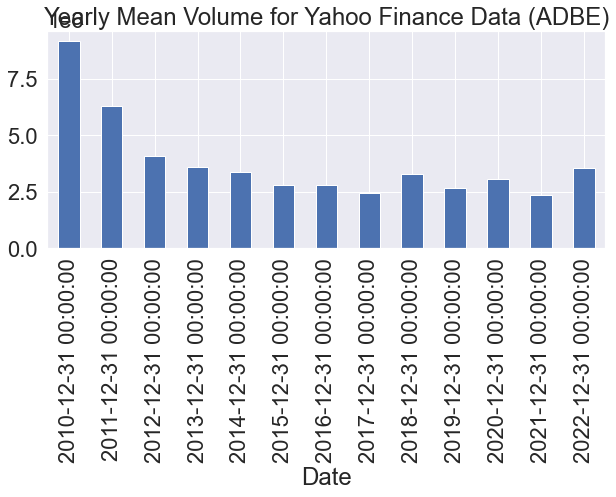

In [79]:
df['Volume'].resample('A').mean().plot(kind='bar',figsize = (10,4))
plt.title('Yearly Mean Volume for Yahoo Finance Data (ADBE)')

<AxesSubplot:xlabel='Date'>

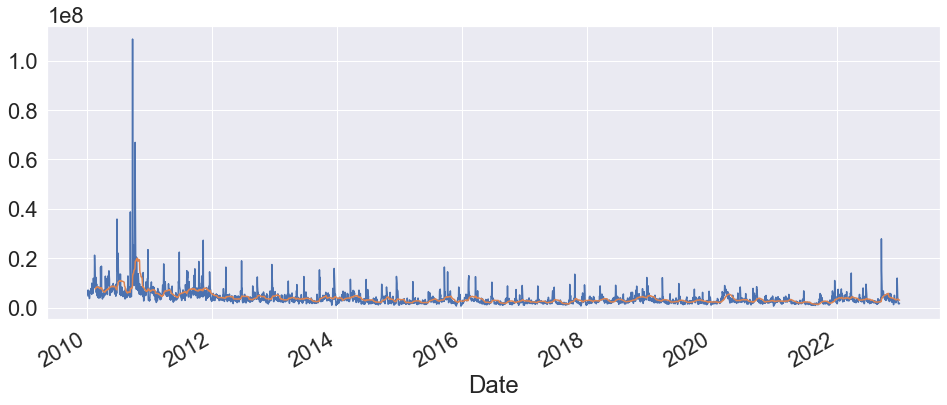

In [80]:
df['Volume'].plot()
df.rolling(window=30).mean()['Volume'].plot(figsize=(16, 6))

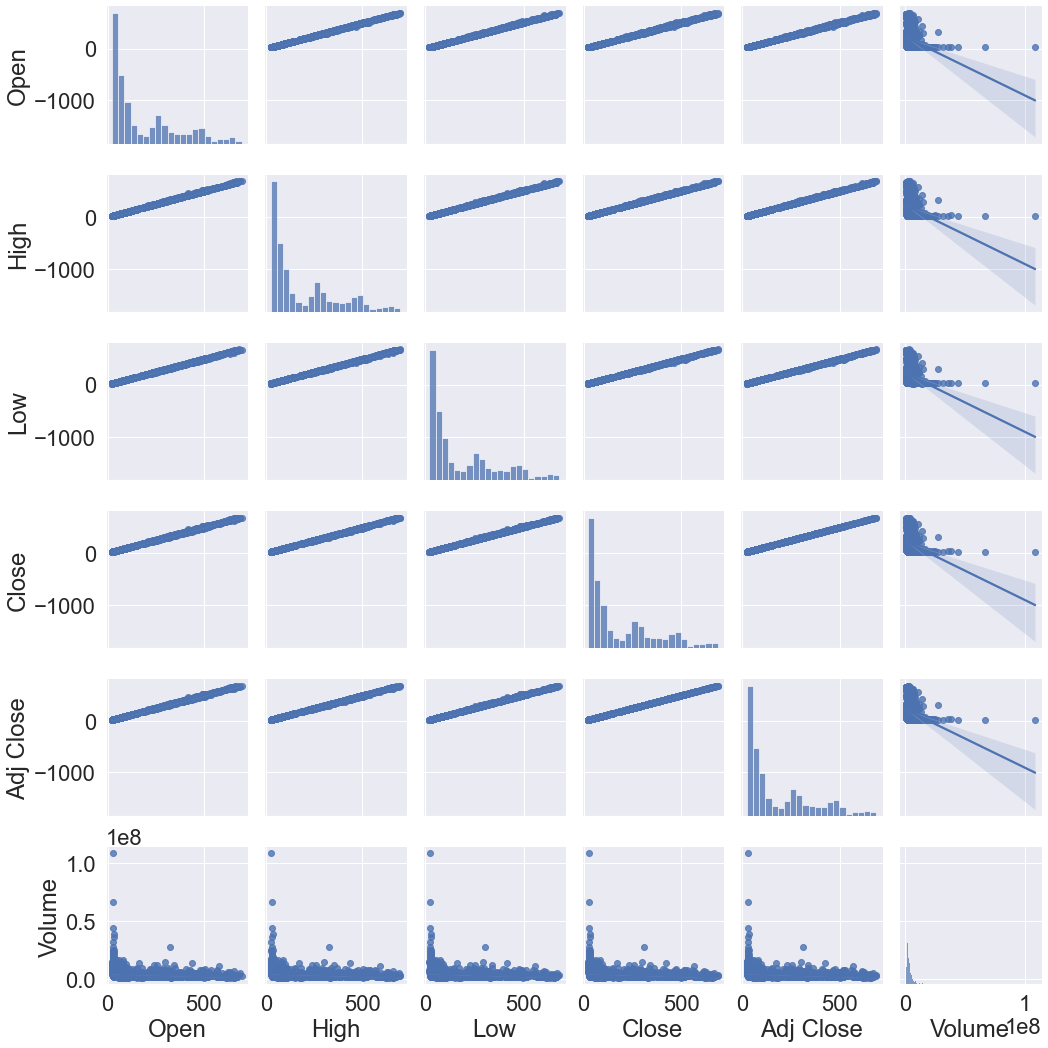

In [81]:

sns.pairplot(df, kind='reg')

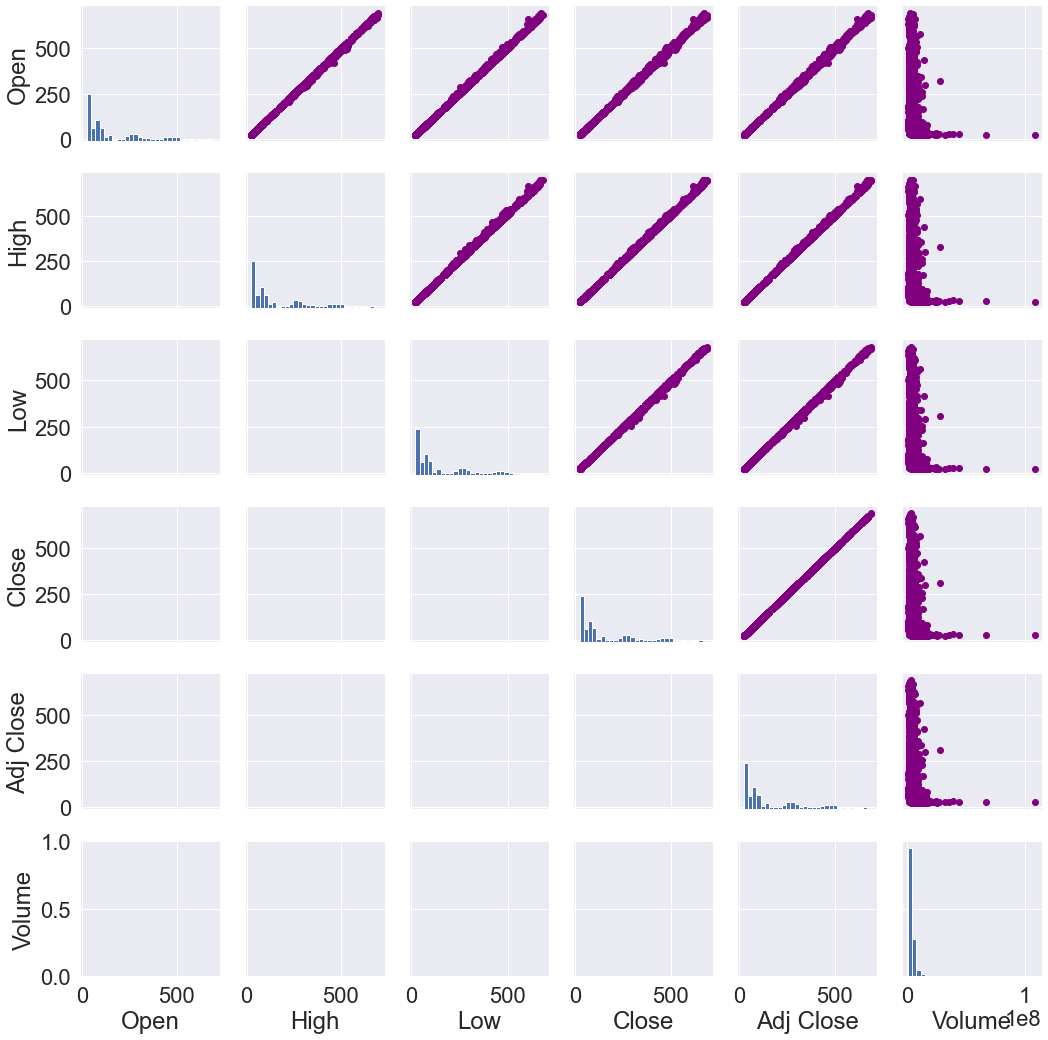

In [83]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(df.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')


# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

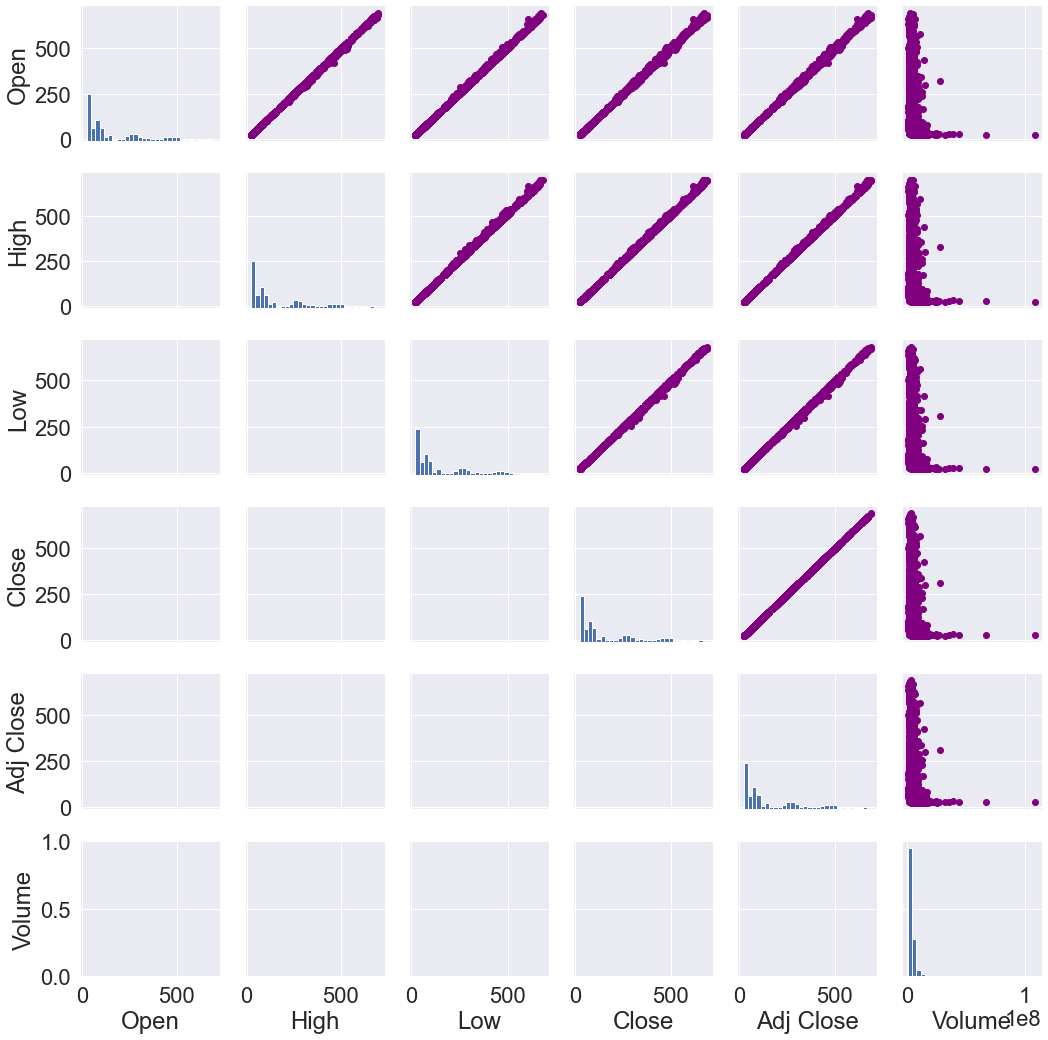

In [84]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')


# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

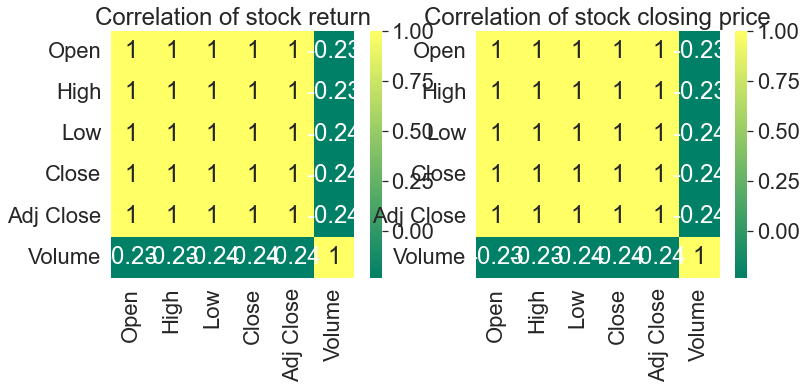

In [85]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')